### Поиск изображений по содержанию (30 баллов)

Вам предстоит построить систему, которая позволит выполнить поиск изображений по содержанию в базе Corel-10k, которая приложена к домашнему заданию. База состоит из 100 классов изображений по 100 изображений в каждом классе. Изображения из одного класса лежат подряд в промежутке 1-100, 101-200, и тд. В файле **test.dat** лежит список картинок, которые не должны участвовать в построении поисковой базы, но по которым надо будет сделать 1000 поисковых запросов. Ограничение по памяти -- 2Гб.

1. По изображениям не попавшим в **test.dat** посчитайте дескриптор с помощью алгоритма GIST.
   
2. Разбейте дескрипторы всех изображений на 100 кластеров с помощью K-Means.

3. Для каждого кластера постройте функцию хэширования (LSH), с помощью которой закодируйте каждое изображение в тренировочной выборке.

4. Релизуйте функцию `retrieve` и сделайте 1000 запросов изображениями из файла **test.dat**.

5. Продемонстрируйте работу `retrieve` на 5-ти случайных изображениях из **test.dat**. Замерьте время исполнения поискового запроса. Сделайте возможность вызвать `retrieve` без построения индекса, то есть приложите в решение индексированную базу, если только время построения индекса не укладывается в 1 минуту.  
    
6. Для каждого запроса нужно оценить APk, где k=10 и посчитать среднее значение этой величины по всем запросам (MAPk).

Так же за это задание можно получить еще до 20-ти дополнительных баллов. Качество поиска вы посчитаете сами, а вот со скоростью есть некоторые трудности, реализуйте ваше решение таким образом, чтобы я мог из командной строки вызвать:

`python cbir.py --retrieve /path/to/image`

1. Вы можете сделать быстрый поиск. Если качество вашего поиска окажется выше, чем медиана качества по всем поисковым движкам, то вы принимаете участие в борьбе за 10 призовых баллов.

2. Вы можете сделать хороший поиск. Если ваш поиск окажется быстрее, чем медиана среднего времени работы других участников, то вы принимаете участие в борьбе за точный поиск.

Для достижения лучших результатов вам придется регулировать несколько параметров алгоритма:
- Дескриптор. Можете взять что угодно вместо GIST
- Количество кластеров k-means
- Длину кода LSH
- etc 

Помните о том, что время поиска очень важный параметр.

In [1]:
import numpy as np
import cv2
import matplotlib.pylab as plt
%matplotlib inline
import pickle
from sklearn.cluster import KMeans
import random

from common import read_test_set
from cbir import APk, class_by_path

In [2]:
def show(img, size=5, title=""):
    plt.figure(figsize=(size,size))
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    if len(img.shape) < 3:
        plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)

In [3]:
def show_5(imgs, labels, size=7, grayscale=False):
    plt.figure(figsize=(size*5, size))
    
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(cv2.cvtColor(cv2.imread(imgs[i]), cv2.COLOR_BGR2RGB))
        if labels[i]:
            plt.title("OK")
        plt.axis('off')

Строим индексированную базу

In [ ]:
!python3 make_index.py

index
Initializing color descriptor...
Color descriptor is saved successfully

Counting train features...
Premature end of JPEG file
Corrupt JPEG data: premature end of data segment
Train features are saved successfully

Training K-means model...


Загружаем данные из индекса

In [5]:
cd = pickle.load(open("index/color_descriptor.p", "rb"))
train_set_index = pickle.load(open("index/train_set_index.p", "rb"))
kmeans = pickle.load(open("index/kmeans.p", "rb"))
lshs = pickle.load(open("index/lshs.p", "rb"))

Считываем тестовый датасет

In [6]:
y_test = read_test_set()
X_test = list(map(cd.describe, y_test))

Выбираем, какие 5 картинок показать

In [10]:
selected_pics = random.sample(range(len(y_test)), 5)

In [ ]:
clusters_predicted = kmeans.predict(X_test)

APks = []

for i in range(len(X_test)):
    cluster = clusters_predicted[i]
    query = X_test[i]
    results = lshs[cluster].query(query)
    query_img_path = y_test[i]
    APks.append(APk(query_img_path, results))
    
    if i in selected_pics:
        show(cv2.imread(query_img_path), title="APk: %.2f" % APks[-1])
        query_class = class_by_path(query_img_path)
        results_classes = np.array(list(map(class_by_path, results))) 
        labels = results_classes == query_class
        show_5(results[:5], labels[:5])
        show_5(results[5:], labels[5:])

Ищем все картинки из теста

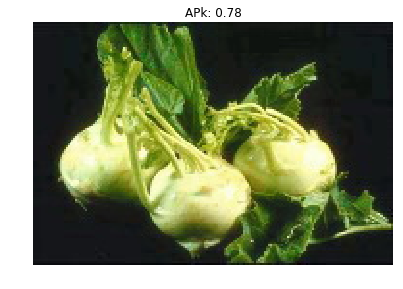

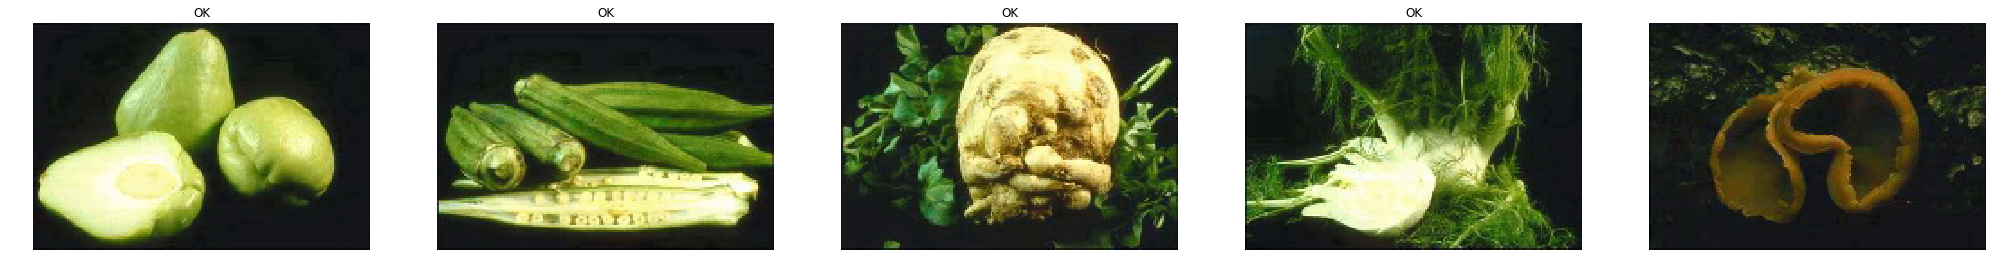

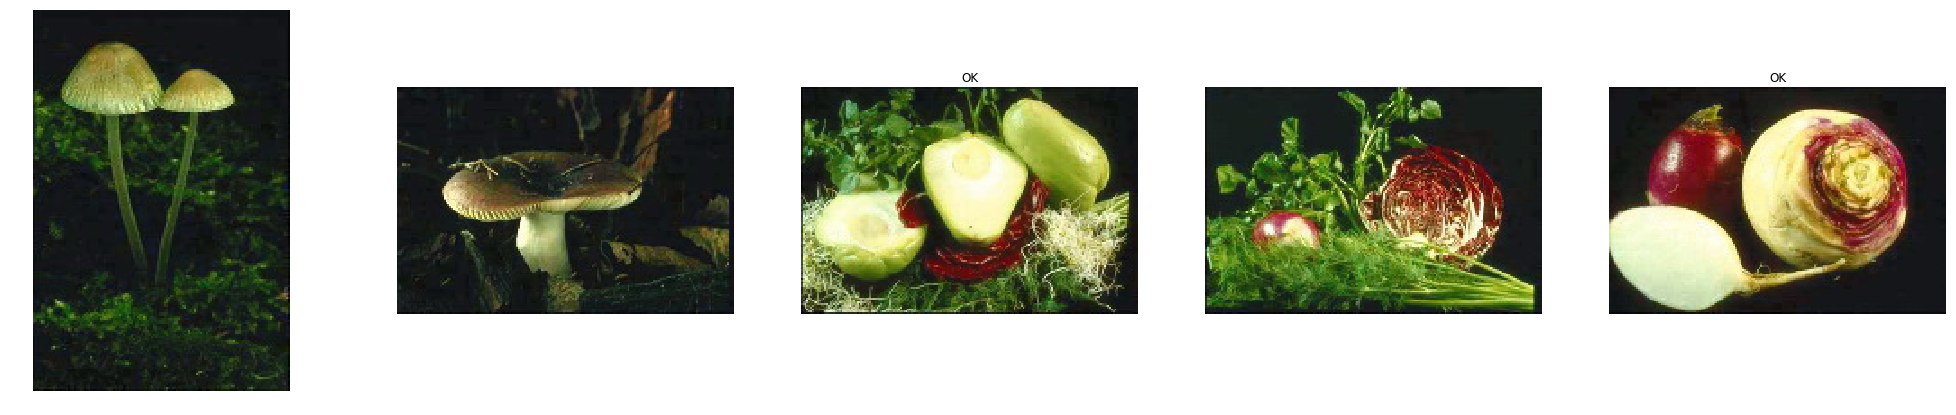

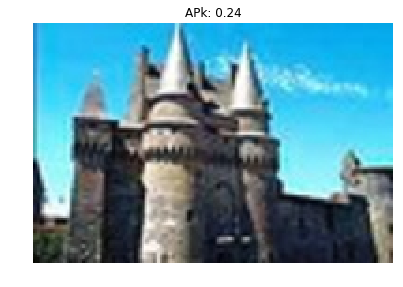

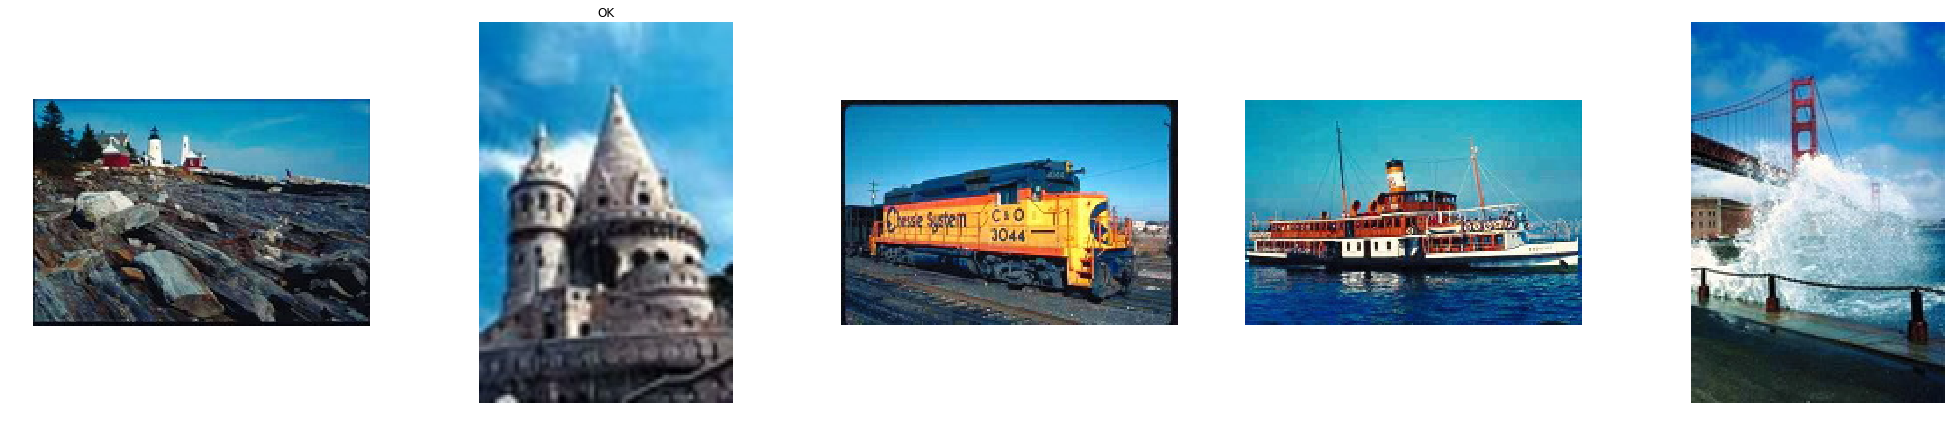

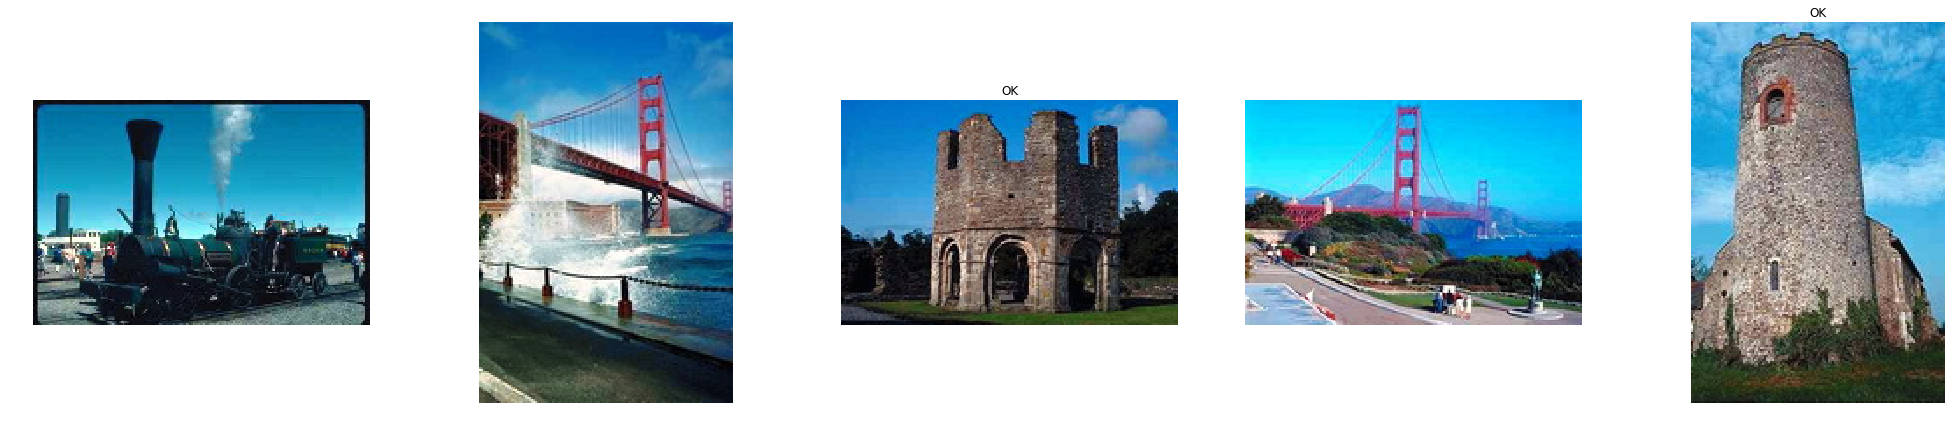

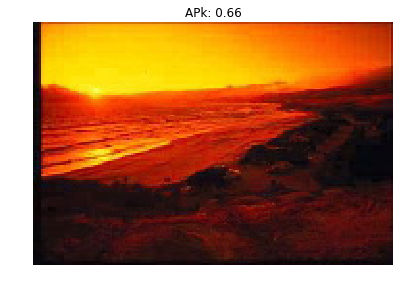

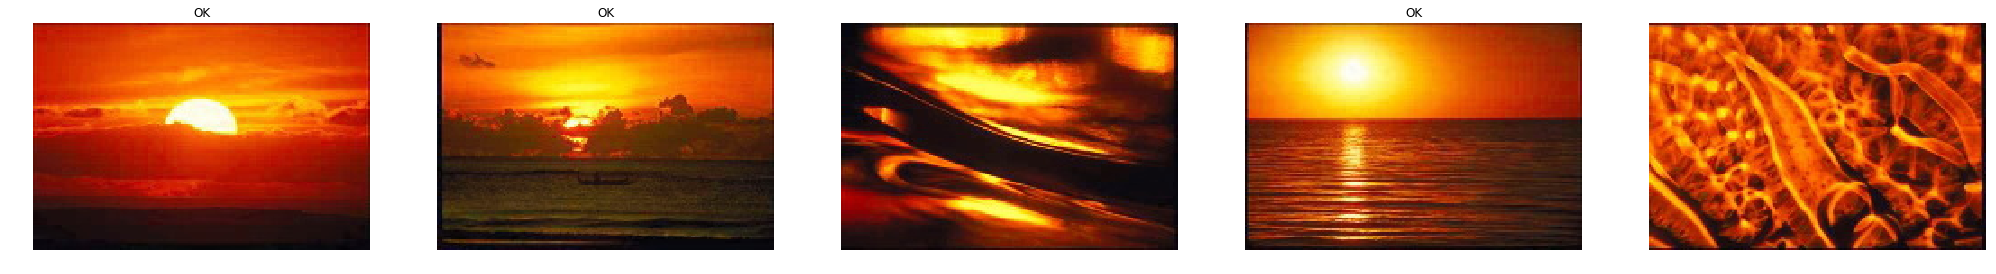

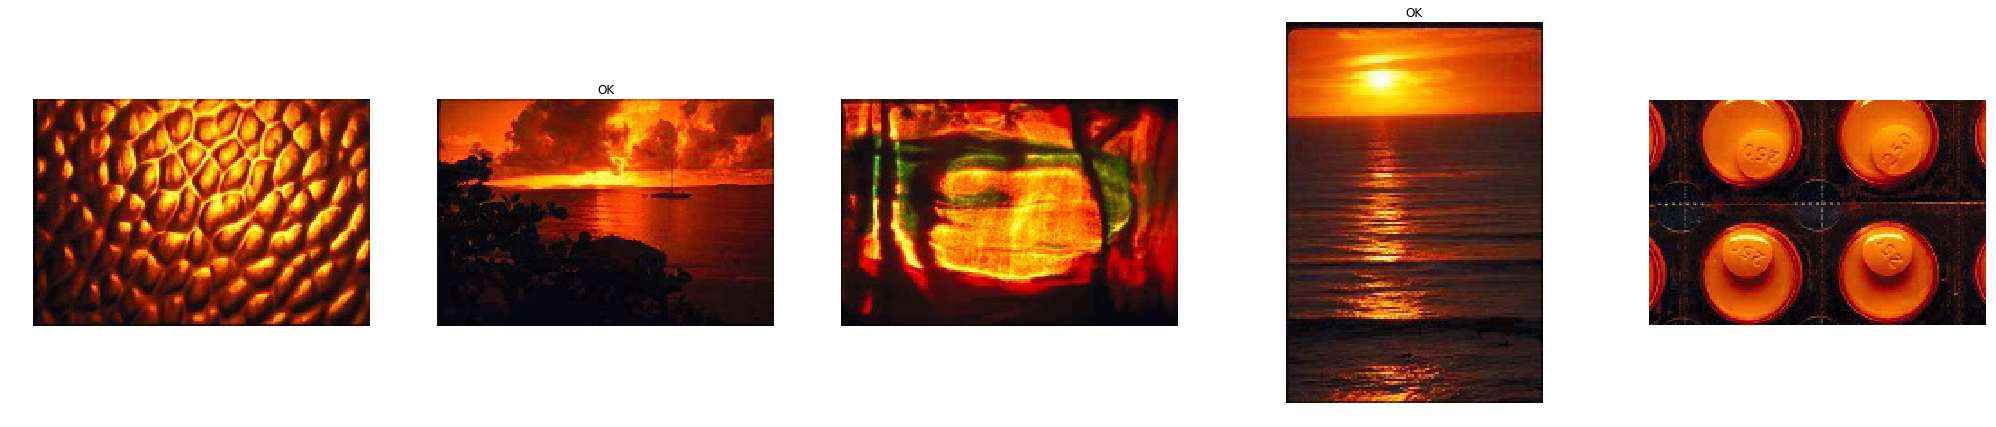

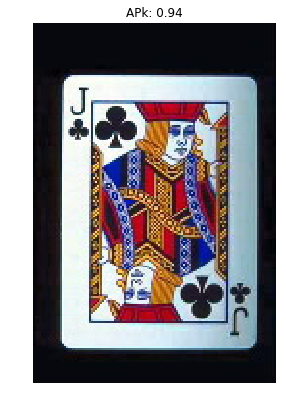

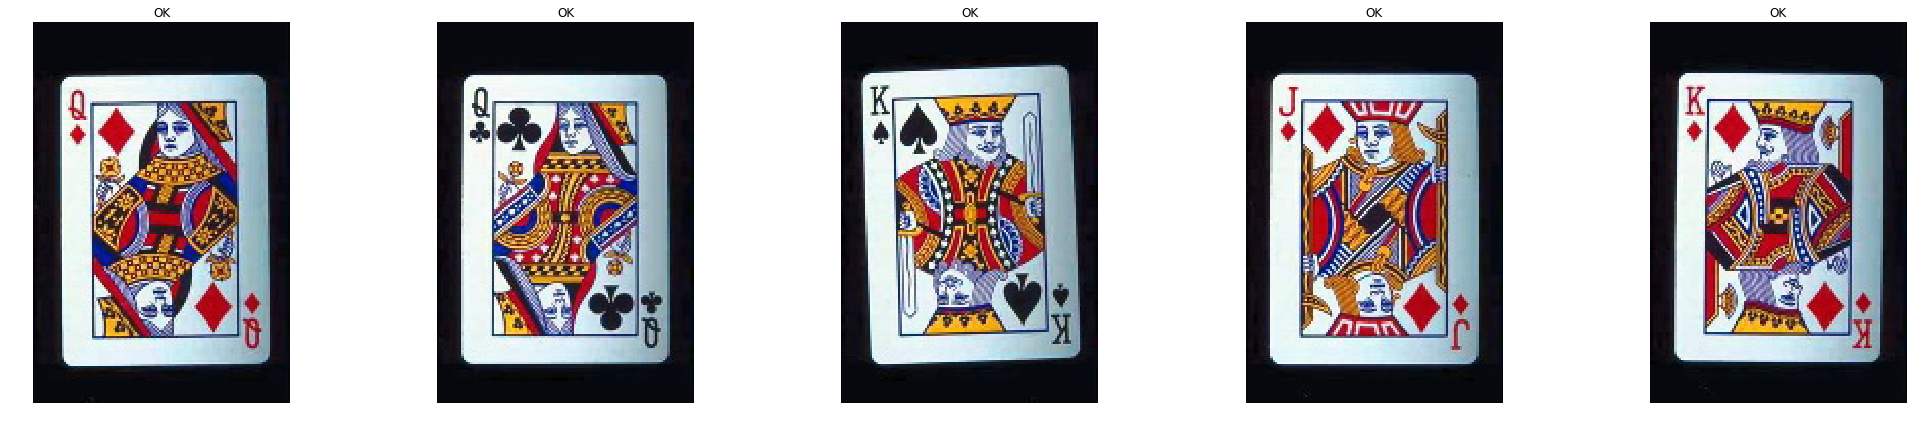

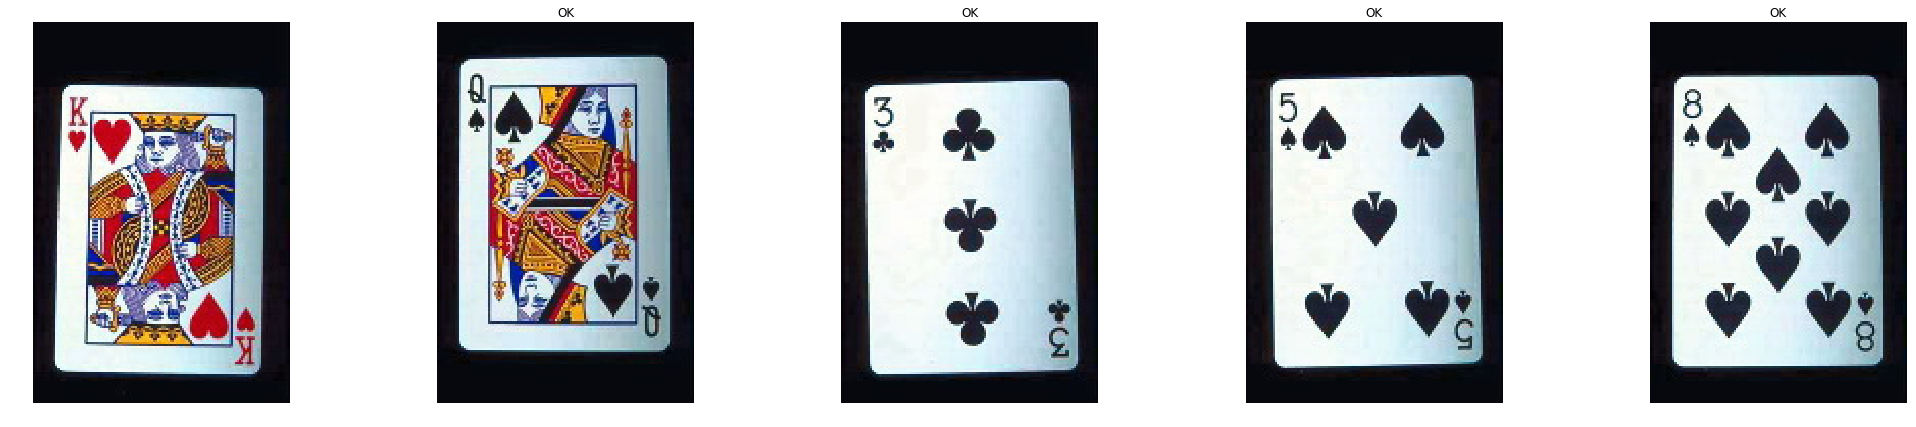

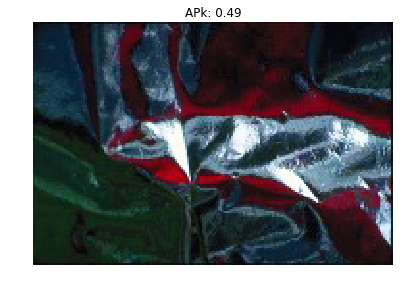

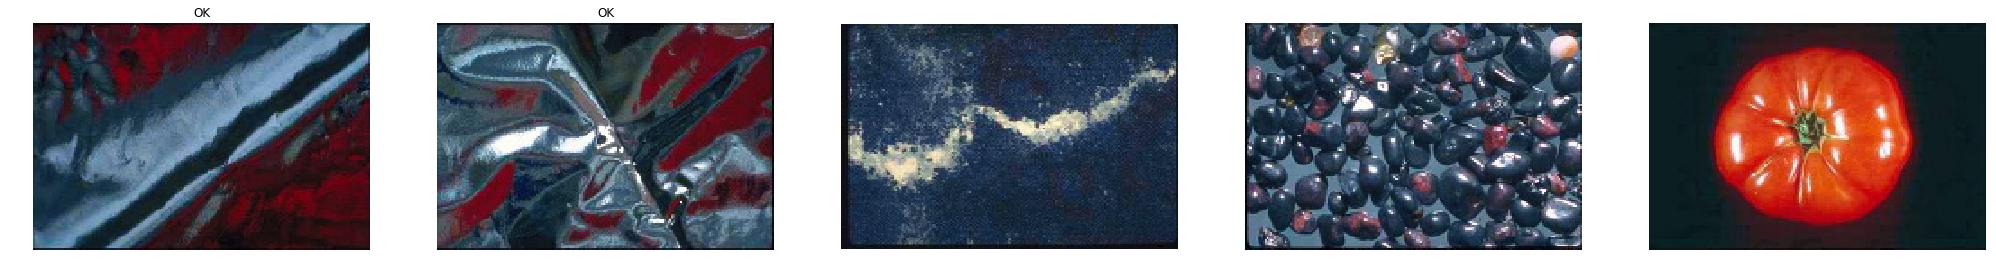

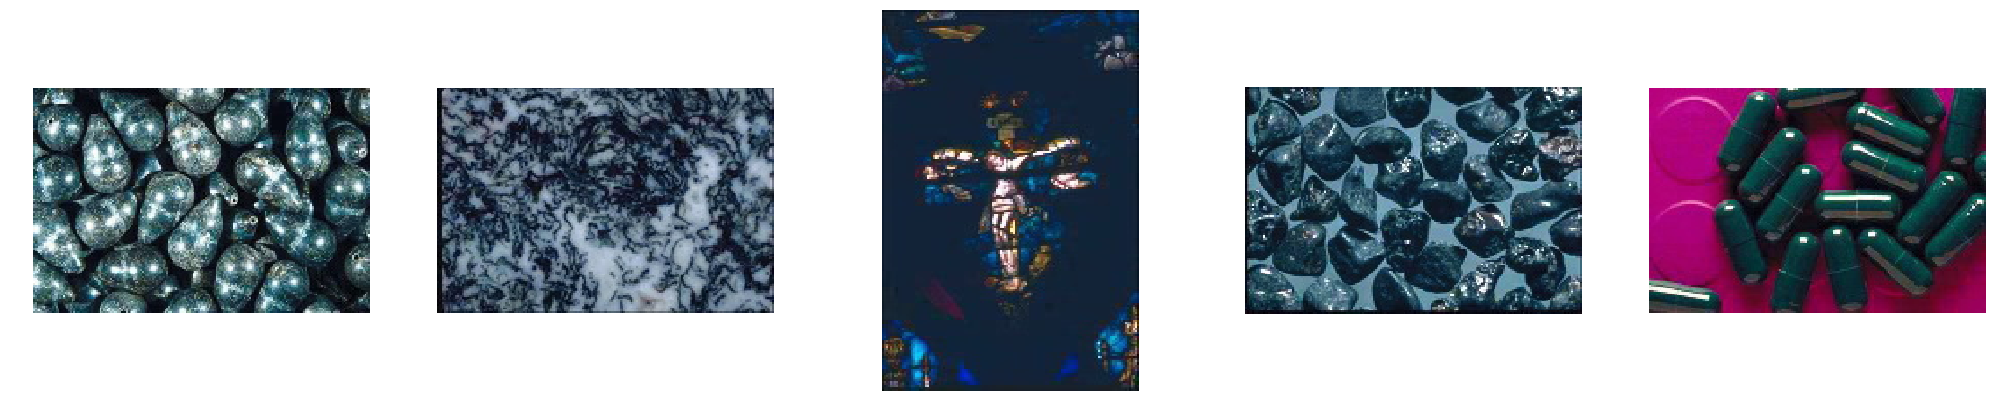

In [11]:
clusters_predicted = kmeans.predict(X_test)

APks = []

for i in range(len(X_test)):
    cluster = clusters_predicted[i]
    query = X_test[i]
    results = lshs[cluster].query(query)
    query_img_path = y_test[i]
    APks.append(APk(query_img_path, results))
    
    if i in selected_pics:
        show(cv2.imread(query_img_path), title="APk: %.2f" % APks[-1])
        query_class = class_by_path(query_img_path)
        results_classes = np.array(list(map(class_by_path, results))) 
        labels = results_classes == query_class
        show_5(results[:5], labels[:5])
        show_5(results[5:], labels[5:])

### Итоговый MAPk

In [12]:
MAPk = np.mean(APks)
MAPk

0.39988551587301585